# Importing Libraries

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import matplotlib.patches as patches
import seaborn as sns
from datetime import datetime
pd.set_option('display.max_columns', 150)

# modeling libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
#from sklearn.grid_search import GridSearchCV

from collections import OrderedDict

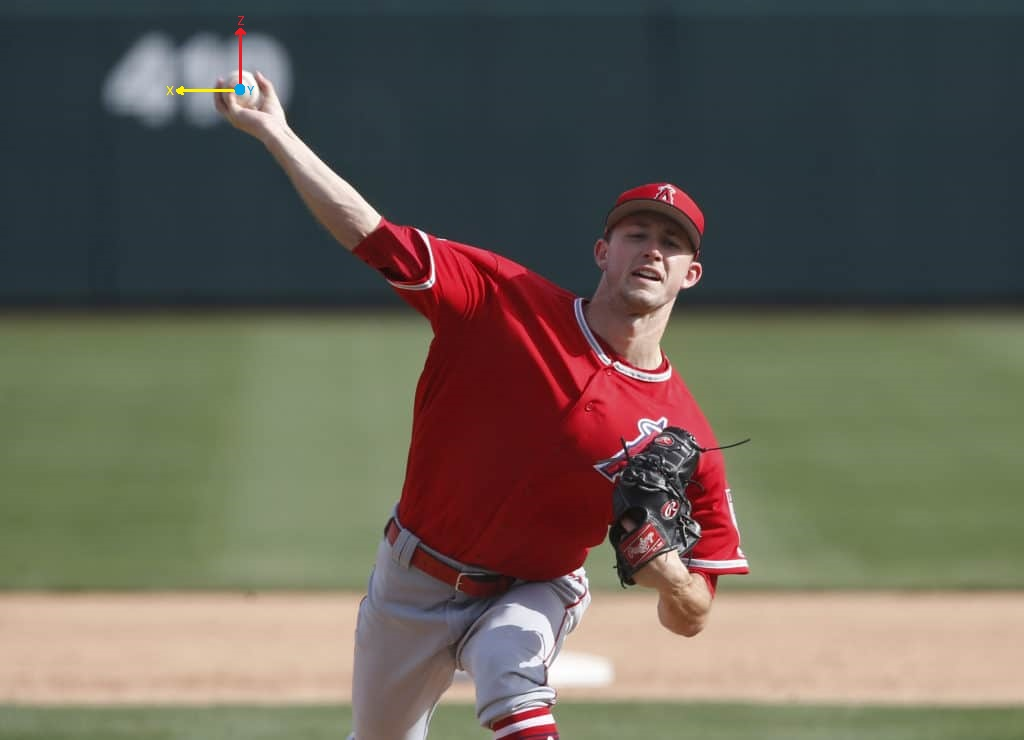

In [55]:
from IPython.display import Image
Image(filename='pitch_pic.jpg') 

To begin familiarizing with some of the features, we will first look at the coordinate system used in the dataset/pfx. The z-direction will be associated to the vertical distance, the x-direction will be associated to the horizontal distance, and the y-direction will be associated towards the catcher/batter. Note that the point of origin changes based on which feature we will be looking at like release position versus the position the ball crosses the plate. 

In [56]:
df = pd.read_csv('savant_data.csv')
print(df.shape)
df.head()

(40000, 89)


,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,spin_dir,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,zone,des,game_type,stand,p_throws,home_team,away_team,type,hit_location,bb_type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,hc_x,hc_y,tfs_deprecated,tfs_zulu_deprecated,fielder_2,umpire,sv_id,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,hit_distance_sc,launch_speed,launch_angle,effective_speed,release_spin_rate,release_extension,game_pk,pitcher.1,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,release_pos_y,estimated_ba_using_speedangle,estimated_woba_using_speedangle,woba_value,woba_denom,babip_value,iso_value,launch_speed_angle,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,FF,2019-06-30,101.3,0.5509,6.1836,Aroldis Chapman,543877,547973,strikeout,swinging_strike,NaN,NaN,NaN,NaN,13.0,Christian Vazquez strikes out swinging.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.1841,0.9995,-0.1572,1.5416,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183411,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,NaN,NaN,NaN,2541.0,6.6473,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.8529,NaN,NaN,0.0,1.0,0.0,0.0,NaN,92,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
1,CH,2019-06-30,87.2,0.5008,6.3708,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,-0.8553,0.1403,-0.1097,2.8397,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183325,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,NaN,NaN,NaN,2812.0,6.2259,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.2743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,2,Changeup,8,12,8,12,12,8,8,12,NaN,NaN
2,FF,2019-06-30,99.4,0.6354,6.2711,Aroldis Chapman,543877,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,0,2019,0.0966,1.5501,0.0167,2.6030,NaN,593523.0,NaN,2,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183244,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,NaN,NaN,NaN,2586.0,6.4608,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,54.0394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,92,1,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
3,FF,2019-06-30,100.0,0.5805,6.2837,Aroldis Chapman,656308,547973,strikeout,foul_tip,NaN,NaN,NaN,NaN,5.0,Michael Chavis strikes out on a foul tip.,R,R,L,BOS,NYY,S,2.0,NaN,0,2,2019,1.0118,1.3386,0.1241,2.3864,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183144,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,NaN,NaN,NaN,2596.0,6.7012,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7990,NaN,NaN,0.0,1.0,0.0,0.0,NaN,91,3,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN
4,FF,2019-06-30,98.6,0.5832,6.2344,Aroldis Chapman,656308,547973,NaN,foul,NaN,NaN,NaN,NaN,5.0,NaN,R,R,L,BOS,NYY,S,NaN,NaN,0,1,2019,0.2288,1.4388,-0.1114,2.2780,NaN,593523.0,NaN,1,9,Bot,NaN,NaN,NaN,NaN,519222.0,NaN,190630_183100,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,NaN,NaN,NaN,2519.0,6.7412,565068,547973,519222.0,518934.0,650402.0,570482.0,544369.0,458731.0,543305.0,643565.0,53.7590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,91,2,4-Seam Fastball,8,12,8,12,12,8,8,12,NaN,NaN


# Cleaning

There are many outcomes that can occur during a pitch so for simplicity we will combine rare events into related outcomes.

In [57]:
# Cleaning for events column by combining similar events to reduce noise in eda and modeling process
# Notes: Triples may need to be labeled into something else due to lack of frequency

df['events'].replace(['fielders_choice', 'fielders_choice_out', 'double_play', 'grounded_into_double_play'], 'field_out', inplace=True)
df['events'].replace('hit_by_pitch', 'walk', inplace=True)
df['events'].replace(['force_out', 'sac_fly', 'sac_bunt'], 'field_out', inplace=True)
df['events'].replace('strikeout_double_play', 'strikeout', inplace=True)
df = df[~df['events'].isin(['caught_stealing_2b', 'field_error', 'catcher_interf', 'pickoff_1b', 'caught_stealing_home', 'pickoff_caught_stealing_2b', 'pickoff_2b'])]


In [58]:
# Cleaning for description column for same reason above

df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('swinging_strike_blocked', 'swinging_strike', inplace=True)
df['description'].replace('missed_bunt', 'called_strike', inplace=True)
df['description'].replace(['foul_tip', 'foul_bunt', 'bunt_foul_tip'], 'foul', inplace=True)
df['description'].replace('blocked_ball', 'ball', inplace=True)
df = df[~df['description'].isin(['pitchout'])]

In [60]:
df = df.drop(['game_date', 'spin_dir', 'spin_rate_deprecated', 
              'break_angle_deprecated', 'break_length_deprecated', 
              'game_type', 'game_year', 'on_3b', 'on_2b', 'on_1b',
              'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2',
              'umpire', 'sv_id', 'fielder_2.1', 'fielder_3',
              'fielder_4', 'fielder_5', 'fielder_6', 'fielder_7', 
              'fielder_8', 'fielder_9', 'pitch_type', 'des', 'home_team', 
              'away_team','launch_speed', 'launch_angle', 'launch_speed_angle', 'hit_distance_sc',
              'pitcher.1', 'if_fielding_alignment', 'of_fielding_alignment', 
              'woba_value', 'woba_denom', 'babip_value', 'iso_value',
              'pitcher', 'batter','hit_location','bb_type', 'hc_y', 'hc_x',
              'estimated_ba_using_speedangle','estimated_woba_using_speedangle','type',
              'post_away_score', 'post_home_score', 'post_bat_score', 'post_fld_score'], axis=1)

# Reordering columns to make it easier to read
cols = df.columns.tolist()
cols = ['player_name','balls','strikes','events', 'description', 'outs_when_up', 'zone',
        'stand', 'p_throws', 'pfx_x', 'pfx_z', 'plate_x', 'plate_z', 'inning',
        'inning_topbot', 'release_speed', 'release_pos_x', 'release_pos_z', 'vx0', 'vy0', 'vz0',
        'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'effective_speed', 'release_spin_rate', 
        'release_extension', 'release_pos_y', 'at_bat_number', 'pitch_number',
        'pitch_name', 'home_score', 'away_score', 'bat_score', 'fld_score', 'game_pk']
df = df[cols]
df.head()

,player_name,balls,strikes,events,description,outs_when_up,zone,stand,p_throws,pfx_x,pfx_z,plate_x,plate_z,inning,inning_topbot,release_speed,release_pos_x,release_pos_z,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,game_pk
0,Aroldis Chapman,0,2,strikeout,swinging_strike,2,13.0,R,L,1.1841,0.9995,-0.1572,1.5416,9,Bot,101.3,0.5509,6.1836,-4.8611,-147.1613,-10.0811,18.5249,36.4048,-15.2666,3.5,1.7,NaN,2541.0,6.6473,53.8529,92,3,4-Seam Fastball,8,12,8,12,565068
1,Aroldis Chapman,0,1,NaN,foul,2,5.0,R,L,-0.8553,0.1403,-0.1097,2.8397,9,Bot,87.2,0.5008,6.3708,0.2824,-126.9700,-2.5902,-9.2334,27.3368,-30.3440,3.5,1.7,NaN,2812.0,6.2259,54.2743,92,2,Changeup,8,12,8,12,565068
2,Aroldis Chapman,0,0,NaN,foul,2,5.0,R,L,0.0966,1.5501,0.0167,2.6030,9,Bot,99.4,0.6354,6.2711,-1.9282,-144.5943,-8.2683,1.8397,36.6497,-8.6289,3.5,1.7,NaN,2586.0,6.4608,54.0394,92,1,4-Seam Fastball,8,12,8,12,565068
3,Aroldis Chapman,0,2,strikeout,foul,1,5.0,R,L,1.0118,1.3386,0.1241,2.3864,9,Bot,100.0,0.5805,6.2837,-3.7012,-145.4269,-8.6002,15.3883,35.3925,-11.1183,3.5,1.7,NaN,2596.0,6.7012,53.7990,91,3,4-Seam Fastball,8,12,8,12,565068
4,Aroldis Chapman,0,1,NaN,foul,1,5.0,R,L,0.2288,1.4388,-0.1114,2.2780,9,Bot,98.6,0.5832,6.2344,-2.4475,-143.4481,-8.7536,3.7733,33.8462,-10.2072,3.5,1.7,NaN,2519.0,6.7412,53.7590,91,2,4-Seam Fastball,8,12,8,12,565068


In [61]:
# We will drop row 987 because mose of the column entries are null and can't be salvaged
df = df[df['release_speed'].notnull()]

# Dropping rows with null effective speed values. Subject to change in future iterations
df = df[df['effective_speed'].notnull()]

# dropping rows where pitch type is unknown (note: consider doing the reverse of what we did for release_spin_rate)
# dropping knuckle ball, forkball, and euphus pitches due to how rare they are
df = df[df['pitch_name'].notnull()]
df = df[~df['pitch_name'].isin(['Eephus', 'Forkball', 'Knuckle Ball'])]

# imputing release_spin_rate with mean values grouped by pitch_name (i.e. curve balls spin the fastest compared to other pitches)
df['release_spin_rate'] = df['release_spin_rate'].fillna(df.groupby('pitch_name')['release_spin_rate'].transform('mean'))

# imputing events with 'nothing' to represent when the batter remains at bat after the result of the at bat attempt
df['events'] = df['events'].fillna('no_event')

# defining response variable that determines if the batter got on base or not (1 for strikes/outs 0 for balls or hits on base)
df['strike_result'] = df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'foul']) * 1

# confirming that there are no more null values
df.isnull().sum()[df.isnull().sum() > 0]

Series([], dtype: int64)

# Feature Engineering

In [62]:
# defining response variable for strikeout type pitchers. anything that wasn't considered a strike was left out
df['strike_result'] = df['description'].isin(['hit_into_play', 'called_strike', 'swinging_strike', 'foul']) * 1


# EDA

The goal is to identify which factors determine a successful pitcher so that the Blue Jays can make cost efficient trades to improve their pitching roster

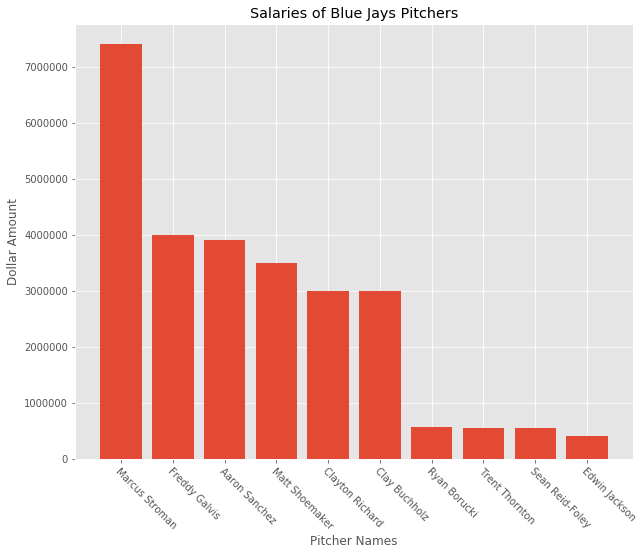

In [63]:
bluejay_pitcher_salary = {'Freddy Galvis':4000000, 
                         'Marcus Stroman':7400000, 
                         'Aaron Sanchez':3900000,
                         'Clayton Richard':3000000,
                         'Trent Thornton':555000,
                         'Sean Reid-Foley':555000,
                         'Matt Shoemaker':3500000,
                         'Clay Buchholz':3000000,
                         'Ryan Borucki':565200,
                         'Edwin Jackson':411792}

test = dict(sorted(bluejay_pitcher_salary.items(), key=lambda x: x[1], reverse=True))

# plot
fig, ax = plt.subplots(figsize=(10,8))
plt.title('Salaries of Blue Jays Pitchers')
plt.xlabel('Pitcher Names')
plt.ylabel('Dollar Amount')
plt.bar(*zip(*sorted(bluejay_pitcher_salary.items(), key=lambda x: x[1], reverse=True)))
plt.xticks(rotation=45)
plt.setp( ax.xaxis.get_majorticklabels(), rotation=-45, ha="left", rotation_mode="anchor");

In [64]:
starting_pitchers_names = df.player_name.loc[df['inning']==1].unique()
starting_pitchers = (df.loc[df.player_name.isin(starting_pitchers_names)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))
best_pitchers = starting_pitchers.head(3)
worst_pitchers = starting_pitchers.tail(3)
pd.concat([best_pitchers, worst_pitchers], axis='rows')



,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Max Scherzer,89.140670,0.708134,209,4-Seam Fastball,-3.444684,54.670836,5.340946,5.828665,-0.463185,0.600982
Bryse Wilson,92.304938,0.691358,81,4-Seam Fastball,-3.299284,54.321744,5.513777,6.177728,-0.547493,0.921809
Noe Ramirez,82.668831,0.688312,77,Curveball,-2.411816,55.078836,4.922806,5.420675,-0.060570,0.070838
Tanner Anderson,91.111712,0.468468,111,Sinker,-2.311677,54.808413,5.998185,5.691081,-0.970132,0.572572
Odrisamer Despaigne,88.869118,0.455882,68,4-Seam Fastball,-1.593065,54.597615,5.673184,5.901882,-0.218191,0.468644
Mike Clevinger,89.707692,0.442308,52,4-Seam Fastball,-1.525148,54.055900,5.531917,6.443596,0.031679,0.632471


In [65]:

game_stats = df.loc[df.player_name.isin(starting_pitchers_names)].sort_values(['game_pk','inning', 'inning_topbot', 'outs_when_up', 'at_bat_number', 'pitch_number'],
             ascending=[False, True, False, True, True, True])
season_stats = (game_stats.groupby(['game_pk', 'player_name'])
                        .agg({'bat_score':lambda x: x.max() - x.min(),
                              'inning': lambda x: x.max() - x.min() + 1}))
season_stats['ERA'] = round(season_stats['bat_score']*9 / season_stats['inning'], 2)

season_stats = test2.groupby('player_name').agg({'ERA':'mean', 'inning':'sum'}).sort_values('ERA').head()

low_era_pitchers = (df.loc[df.player_name.isin(season_stats.index)]
                        .groupby('player_name')
                        .agg({'release_speed':'mean',
                              'strike_result':'mean',
                              'at_bat_number':'count',
                              'pitch_name':lambda x:x.value_counts().index[0],
                              'release_pos_x':'mean',
                              'release_pos_y':'mean',
                              'release_pos_z':'mean',
                              'release_extension':'mean',
                              'pfx_x':'mean',
                              'pfx_z':'mean'})
                        .sort_values(by='strike_result', ascending=False))

low_era_pitchers


,release_speed,strike_result,at_bat_number,pitch_name,release_pos_x,release_pos_y,release_pos_z,release_extension,pfx_x,pfx_z
player_name,,,,,,,,,,
Daniel Mengden,86.002151,0.645161,93,4-Seam Fastball,-1.611784,54.275319,5.885624,6.224161,-0.150159,0.733908
John Means,87.236145,0.614458,83,4-Seam Fastball,0.680183,54.638670,6.519657,5.860867,0.578743,1.417798
Chad Green,94.703571,0.607143,28,4-Seam Fastball,-2.101182,54.310464,5.913082,6.189000,-0.452057,1.132879
Matt Carasiti,94.151111,0.555556,45,Sinker,-2.064160,54.666064,6.035233,5.833333,-0.977502,0.820591
Aaron Civale,86.677907,0.511628,86,Sinker,-1.305345,55.185731,6.018490,5.313802,-0.232423,0.449184


We will now compare 3 pitchers with very different skill levels. Max Scherzer who has the best strike rate, Aaron Civale who is one of the pitchers who hasn't allowed a run this whole season, and Mike Clevinger who is not having the best season this year. By grouping by the different pitches that these pitchers can use, we can discover subtle differences between them.

In [66]:
player_comparison = (df[df.player_name.isin(['Max Scherzer', 'Mike Clevinger', 'Aaron Civale'])]
 .groupby(['pitch_name','player_name'])
 .agg({'release_speed':'mean',          
      'at_bat_number':'count',
      'pitch_name':lambda x:x.value_counts().index[0],
       'vx0':'mean',
       'vy0':'mean',
       'vz0':'mean',
       'ax':'mean',
       'ay':'mean',
      'release_pos_x':'mean',
      'release_pos_y':'mean',
      'release_pos_z':'mean',
      'release_extension':'mean',
      'release_spin_rate':'mean',
      'pfx_x':'mean',
      'pfx_z':'mean',
      'strike_result':'mean'})
)
player_comparison

release_speed  at_bat_number       pitch_name  \
pitch_name      player_name                                                     
4-Seam Fastball Aaron Civale        91.450000              4  4-Seam Fastball   
                Max Scherzer        95.295455             88  4-Seam Fastball   
                Mike Clevinger      96.303704             27  4-Seam Fastball   
Changeup        Aaron Civale        83.360000              5         Changeup   
                Max Scherzer        83.939394             33         Changeup   
                Mike Clevinger      90.000000              8         Changeup   
Curveball       Aaron Civale        73.633333              9        Curveball   
                Max Scherzer        78.418750             16        Curveball   
                Mike Clevinger      77.788889              9        Curveball   
Cutter          Aaron Civale        86.754167             24           Cutter   
                Max Scherzer        89.911765             17           Cutter   
Sinker          Aaron Civale        91.402941             34           Sinker   
Slider          Aaron Civale        81.920000             10           Slider   
                Max Scherzer        85.294545             55           Slider   
                Mike Clevinger      80.562500              8           Slider   

                                      vx0         vy0       vz0         ax  \
pitch_name      player_name                                                  
4-Seam Fastball Aaron Civale     4.227500 -133.067700 -2.592625  -6.067925   
                Max Scherzer    11.162019 -138.214139 -4.728298 -14.924670   
                Mike Clevinger   4.045226 -140.220889 -5.986300  -6.778993   
Changeup        Aaron Civale     4.075560 -121.212440 -3.554020 -12.778820   
                Max Scherzer     9.068003 -121.845679 -2.803448 -14.309473   
                Mike Clevinger   5.507850 -131.048587 -5.709325 -13.030487   
Curveball       Aaron Civale     0.080178 -106.938022  1.911789   7.281722   
                Max Scherzer     4.471944 -114.077500  0.748044   7.170719   
                Mike Clevinger  -0.632089 -113.185689  1.228133   8.352656   
Cutter          Aaron Civale     2.983129 -126.293875 -2.962996   4.757800   
                Max Scherzer    10.041453 -130.517847 -4.484559  -1.294006   
Sinker          Aaron Civale     5.954979 -132.855147 -4.652424 -15.043135   
Slider          Aaron Civale     4.007280 -119.075220 -2.801410   6.410990   
                Max Scherzer     8.651307 -123.850404 -1.478180   1.413389   
                Mike Clevinger  -0.439412 -117.269825 -0.441037  14.707512   

                                       ay  release_pos_x  release_pos_y  \
pitch_name      player_name                                               
4-Seam Fastball Aaron Civale    24.472525      -1.289675      54.998700   
                Max Scherzer    29.418499      -3.393165      54.615100   
                Mike Clevinger  30.679911      -1.624515      53.804385   
Changeup        Aaron Civale    21.358160      -1.478200      55.114540   
                Max Scherzer    22.829933      -3.469291      54.626206   
                Mike Clevinger  24.670412      -1.454425      53.595487   
Curveball       Aaron Civale    19.474067      -1.131867      55.341589   
                Max Scherzer    19.181556      -3.344212      54.949612   
                Mike Clevinger  19.815867      -1.253789      54.758756   
Cutter          Aaron Civale    20.851221      -1.204033      55.361229   
                Max Scherzer    24.485988      -3.466041      54.716247   
Sinker          Aaron Civale    25.941035      -1.361356      54.951447   
Slider          Aaron Civale    20.519620      -1.434030      55.531240   
                Max Scherzer    24.174227      -3.534978      54.691658   
                Mike Clevinger  21.951837      -1.565788      54.574463   

                                release_pos_z  rele

Speed doesn't seem to be the most important factor that determines a strike as originally assumed. As observed for Mike Clevinger's 4-seam fastball release_speed, one can see that he has the fastest pitch but simultaneously the worst performance amongst the two other pitchers.

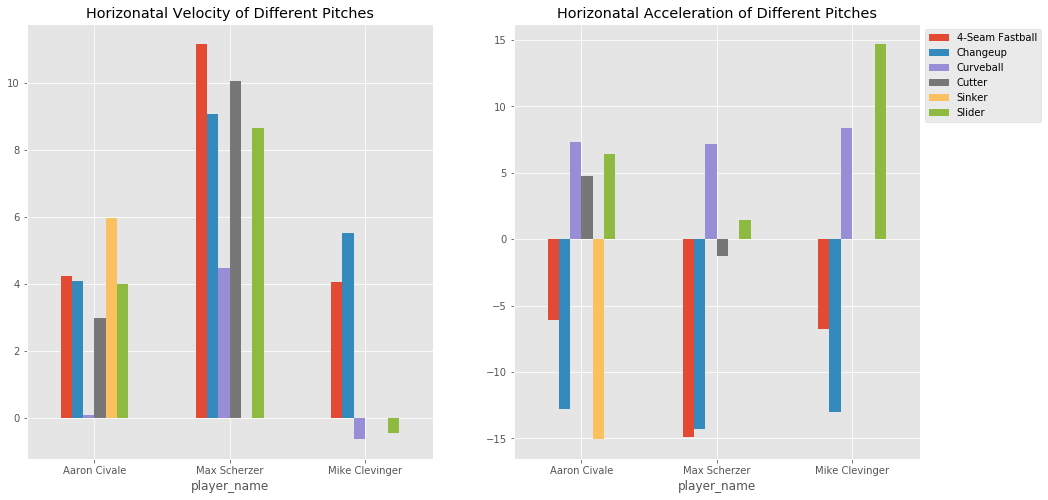

In [67]:
fig3, (ax3, ax4) = plt.subplots(1,2, figsize=(16,8))

_ = player_comparison['vx0'].unstack(level=0).plot(kind='bar', rot=0, ax=ax3, legend=False)
_ = ax3.set_title('Horizonatal Velocity of Different Pitches')
#_ = ax3.legend(bbox_to_anchor=(1,1), loc='upper left')

_ = player_comparison['ax'].unstack(level=0).plot(kind='bar', rot=0, ax=ax4)
_ = ax4.set_title('Horizonatal Acceleration of Different Pitches')
_ = plt.legend(bbox_to_anchor=(1,1), loc='upper left')

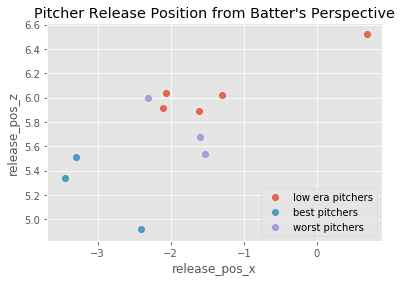

In [68]:

_ = sns.regplot('release_pos_x', 'release_pos_z', data=low_era_pitchers, fit_reg=False, label='low era pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=best_pitchers, fit_reg=False, label='best pitchers')
_ = sns.regplot('release_pos_x', 'release_pos_z', data=worst_pitchers, fit_reg=False, label='worst pitchers')
_ = plt.title('Pitcher Release Position from Batter\'s Perspective')
_ = plt.legend(loc='lower right')

For ease of understanding, imagine the pitcher standing where x-axis equals zero, and the point of release is where the dot lies on the plot. The difference in the horizonatal release points between the good and bad pitchers is a really interesting pattern. From this observation we can hypothesize that pitchers who release the ball further left or right from their body higher success rate of striking out batters. height and arm length may be a big contributing factor in release_pos_x as well.

Note: negative values of release_pos_x represent right handed pitchers and postive x values correspond to left handers

Z:\Users\Don\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


''

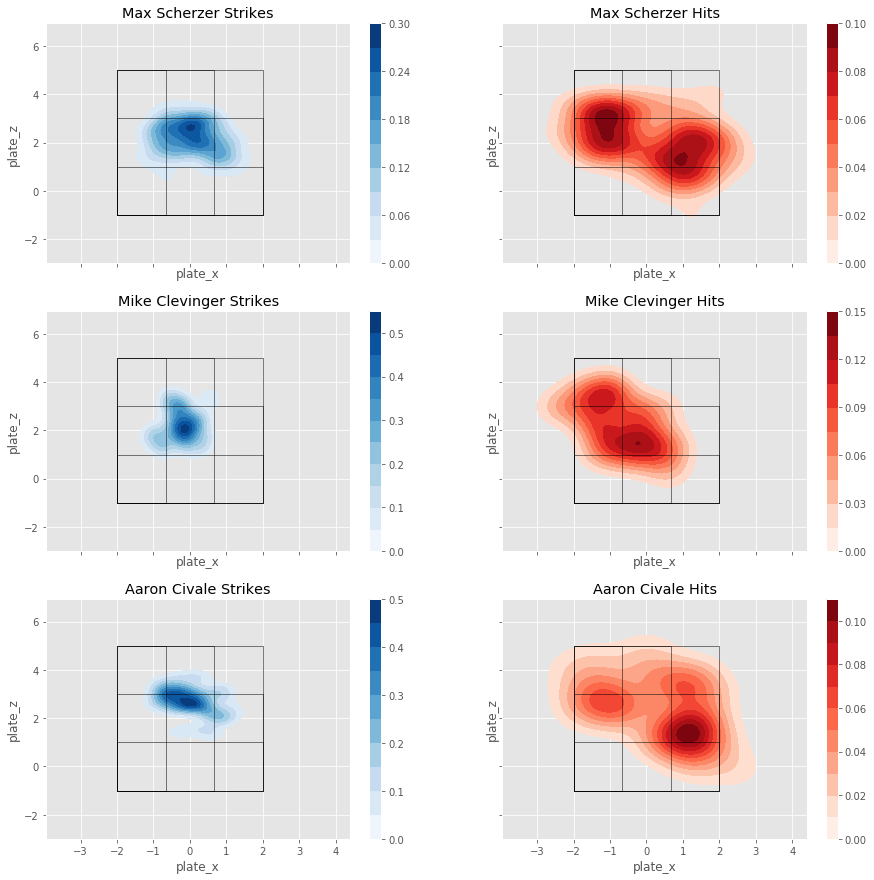

In [69]:
scherzer_strikes = df[(df['player_name']=='Max Scherzer')  & (df.strike_result==1)]
clevinger_strikes = df[(df['player_name']=='Mike Clevinger')  & (df.strike_result==1)]
civale_strikes = df[(df['player_name']=='Aaron Civale')  & (df.strike_result==1)]
scherzer_hits = df[(df['player_name']=='Max Scherzer') & (df.strike_result==0)]
clevinger_hits = df[(df['player_name']=='Mike Clevinger') & (df.strike_result==0)]
civale_hits = df[(df['player_name']=='Aaron Civale') & (df.strike_result==0) ]
 


fig, ax = plt.subplots(3, 2, sharex=True, sharey=True, figsize=(15,15))

for i in range(0,3):
    for j in range(0,2):
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 4, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), 4, 2, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (4/3), 6, fill=False, edgecolor='black'))
        ax[i,j].add_patch(patches.Rectangle((-2, -1), (8/3), 6, fill=False, edgecolor='black'))

sns.kdeplot(scherzer_strikes['plate_x'] , scherzer_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[0,0], cbar=True).set_title('Max Scherzer Strikes')
sns.kdeplot(clevinger_strikes['plate_x'] , clevinger_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[1,0], cbar=True).set_title('Mike Clevinger Strikes')
sns.kdeplot(civale_strikes['plate_x'] , civale_strikes['plate_z'], cmap="Blues", shade=True, shade_lowest=False, ax=ax[2,0], cbar=True).set_title('Aaron Civale Strikes')

sns.kdeplot(scherzer_hits['plate_x'] , scherzer_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[0,1], cbar=True).set_title('Max Scherzer Hits')
sns.kdeplot(clevinger_hits['plate_x'] , clevinger_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[1,1], cbar=True).set_title('Mike Clevinger Hits')
sns.kdeplot(civale_hits['plate_x'] , civale_hits['plate_z'], cmap="Reds", shade=True, shade_lowest=False, ax=ax[2,1], cbar=True).set_title('Aaron Civale Hits')
;

The best pitcher(Max) seems to have a larger distribution that spreads across zones 4,5,6 whereas the worst pitcher(Mike) has a smaller distribution concentrated around zone 5. This may be a major contributing factor towards Max's success as a pitcher. Note that the difference between the bottom distributions (pitches that got hit) may be due to different type of pitches or fatigue. This may require more investigation.

There are a few interesting hypothesis that can be drawn from the two graphs seen above:          
    1) higher release_pos_x (aka greater height/longer arms) is directly related to the likelihood of throwing a strike     
    2) A more varied toolbox of different pitches can lead to a lower ERA amount     
    3) The more similar the fastball and changeup pitches look (in terms of vx, ax), the more successful they can be at striking batters out          
    4) The more zones the pitcher can pitch to can lead to a higher chance to striking the batter out